# Import libraries

In [45]:
import pandas as pd
import numpy as np
#
# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split


# Prediction visualisation
import matplotlib.cm as cm # Used later on, has to be included in codeblock where it is used due to same name of functions in other packages


# Tree Visualisation
import os
from sklearn.tree import export_graphviz

from subprocess import call
from IPython.display import Image


# !!! make sure that the files are in the same folder
import data_prep

# Run and import the simulation model

In [2]:
# Run the model
import Snowmeltmodel

# Assign static features ---- array has length of 1x( all pixels )
dem = Snowmeltmodel.dem_array

# Assign dynamic features ---- array has length of (timesteps)x( all pixels )
snow = Snowmeltmodel.snow_array
precipitation = Snowmeltmodel.precipitation_array
temp = Snowmeltmodel.temp_array
snowfall = Snowmeltmodel.snowfall_array
rainfall = Snowmeltmodel.rainfall_array
actualmelt = Snowmeltmodel.actualmelt_array
runoff = Snowmeltmodel.runoff_array

#Retrieve size of frame and timesteps
horizontal_pixels  = Snowmeltmodel.horizontal_pixels
vertical_pixels = Snowmeltmodel.vertical_pixels
timesteps = Snowmeltmodel.timesteps

.....................................................................................................................................................................................

# Data preparation

In [3]:
# Assign feature of interest to 'data'
data = snow

In [4]:
# Repeat Static drivers for each timestep
dem = np.repeat(dem, timesteps)

In [5]:
# create list of drivers and names
list_drivers = [precipitation,temp,snowfall,rainfall,actualmelt,runoff, dem]
list_driver_names = ['precipitation','temp','snowfall','rainfall','actualmelt','runoff', 'dem']

In [ ]:
# Get driver name as string for feature name
# name = f'{runoff=}'.split('=')[0]

#### Add neighbours of feature of interest as features

In [6]:
# Extract the neighbours as features
# Set the results of the next timestep as labels for each timestep.
# Remove the last ran timestep of each simulation to avoid NaN's

df = data_prep.neighbour_as_feature(data, horizontal_pixels, vertical_pixels, multiplesteps =False)

Total number of data points :  216000
Length of one row of pixels, horizontal side of the grid:  30


#### Add drivers as features

In [7]:
# Add drivers at each timestep and each pixel to the dataframe
for _ in range(len(list_drivers)):
    driver = list_drivers[_]
    name = list_driver_names[_]

    # Add driver at each timestep and each pixel to the dataframe
    df = data_prep.driver_as_feature(df=df,
                                     driver=driver, driver_name=name,
                                     horizontal_pixels=horizontal_pixels,
                                     vertical_pixels=vertical_pixels,
                                     multiplesteps=False)


In [8]:
# Name features and labels
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Extract feature names for later processing
colnames = list(df.columns.values.tolist())
feature_names = colnames[:-1]
label_name = colnames[-1]

## Check data preparation

In [9]:
print(feature_names)
print(features.shape)
print(label_name)
print(labels.shape)

['x_input', 'left', 'top_left', 'top', 'top_right', 'right', 'bottom_right', 'bottom', 'bottom_left', 'precipitation', 'temp', 'snowfall', 'rainfall', 'actualmelt', 'runoff', 'dem']
(216000, 16)
y_label
(216000,)


In [10]:
df.head()

,x_input,left,top_left,top,top_right,right,bottom_right,bottom,bottom_left,precipitation,temp,snowfall,rainfall,actualmelt,runoff,dem,y_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,8.472600,0.0,0.000087,0.0,0.000087,878.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,6.942600,0.0,0.000087,0.0,0.000087,878.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,6.942600,0.0,0.000087,0.0,0.000087,878.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,5.637600,0.0,0.000087,0.0,0.000087,878.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,8.127601,0.0,0.000087,0.0,0.000087,878.0,0.0


# Split train/test

#### Train on ALL
#### Test on first stage and time dependent driver

In [11]:
# Split at last timestep to predict last timestep
X_train = features.iloc[:, :]
y_train = labels.iloc[:]

X_test = features.iloc[:(horizontal_pixels*vertical_pixels), :]

# Since we want to predict the entire simulation we do not have a set ylabel. Perhaps later construct y_label from all following simulated steps. But time series of important points generates a better view of the performance
y_test =  labels.iloc[:]

# Check train/test split shapes

In [12]:
print('X_train ', X_train.shape) #training features
print('Y_train ', y_train.shape) #training labels

print('X_test ', X_test.shape) #testing features
print('Y_test (multiplestep Y>>X)', y_test.shape) #testing labels

print('Features ', features.shape) #total just to check if testing is really not inside training. shapes add up
print('Labels ', labels.shape)

X_train  (216000, 16)
Y_train  (216000,)
X_test  (1200, 16)
Y_test (multiplestep Y>>X) (216000,)
Features  (216000, 16)
Labels  (216000,)


# Model optimisation

In [ ]:
 # Altogether, there are 8 * 2 * 10 * 2 * 4 * 2 = 2560 possible settings.
# However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 8)]
# Number of features to consider at every split
max_features = [1.0 , 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 51, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

##### perform hyper parameter optimisation

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 400 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 150,
                               cv = 3,
                               verbose=4,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

# Fit model (Regression - snowmodel)

In [36]:
rf = RandomForestRegressor(n_estimators =  500,
                           min_samples_split = 2,
                           min_samples_leaf = 4,
                           max_features = 'auto',
                           max_depth =  150,
                           bootstrap = True)
rf.fit(X_train, y_train)

C:\Users\rtene\miniconda3\envs\ssml\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=150, max_features='auto', min_samples_leaf=4,
                      n_estimators=500)

# Predict one complete simulation -- add correct driver at each timestep

In [37]:
# -1 timestep due to removed last timesteps to avoid NaN's in Labels
steps = timesteps-1

# Initialise for saving predictions for animation and performance measures, respectively.
framed_predictions = pd.DataFrame()
array_predictions = np.empty(0)

#Choose the initial starting state of the model as the Test set
X_test_multiple = X_train.iloc[:(horizontal_pixels*vertical_pixels),:]

# - Make predictions
# - Save prediction
# - Set prediction as new input
# - Set neighbours for new input
# - Add static and dynamic drivers to new input
last_pixel_driver = 0
for _ in range(steps):
    print(_)
    # Prediction step
    y_pred_rf = rf.predict(X_test_multiple)

    # Save the solution as a dataframe of pixels
    # For animation
    projected_prediction = pd.DataFrame(np.reshape(y_pred_rf,(int(vertical_pixels),int(horizontal_pixels))))
    framed_predictions = pd.concat([framed_predictions, projected_prediction], axis=0)

    # For performance measures
    array_predictions = np.append(array_predictions, y_pred_rf)


    # Create the new test set for next prediction
    new_state = data_prep.neighbour_as_feature(y_pred_rf.reshape(-1,1),
                                               horizontal_pixels,
                                               vertical_pixels,
                                               multiplesteps=True,
                                               print_true= False)

    # Add the drivers at that timestep
    first_pixel_driver = last_pixel_driver
    last_pixel_driver = first_pixel_driver + (vertical_pixels*horizontal_pixels)
    for __ in range(len(list_drivers)):
        driver = list_drivers[__]
        name = list_driver_names[__]
        new_state = data_prep.driver_as_feature(df = new_state,
                                                driver=driver[first_pixel_driver:(last_pixel_driver)],
                                                driver_name= name,
                                                horizontal_pixels=horizontal_pixels,
                                                vertical_pixels=vertical_pixels,
                                                multiplesteps=True)
    # # Check if the driver is added properly
    # colnames = list(df.columns.values.tolist())
    # print(colnames)
    # if _ == 50:
    #     print(new_state)


    # remove the Y_label-- y_label only used for training
    X_test_multiple = new_state.iloc[:, :-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


# Model performance

In [38]:
def evaluate(predictions, test_labels):
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

accuracy = evaluate(predictions=array_predictions, test_labels=y_test)

Model Performance
Average Error: 0.0165 degrees.
Accuracy = -inf%.


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score,max_error

# Mean absolute percentage error (MAPE) regression loss.
#
# Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2. Furthermore, the output can be arbitrarily high when y_true is small (which is specific to the metric) or when abs(y_true - y_pred) is large (which is common for most regression metrics).


MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred = array_predictions)
MAE = mean_absolute_error(y_true=y_test, y_pred = array_predictions)
MSE = mean_squared_error(y_true=y_test, y_pred = array_predictions)
MAX = max_error(y_true=y_test, y_pred = array_predictions)
EXPL_VAR = explained_variance_score(y_true=y_test, y_pred = array_predictions)

# print('mean absolute percentage: ', MAPE) Too small y_true values for this measure??
print('mean absolute error: ',MAE)
print('mean squared error: ',MSE)
print('MAX ERROR: ',MAX)
print('Explained variance score: ',EXPL_VAR)


mean absolute error:  0.016456724578601572
mean squared error:  0.0013346007980947997
MAX ERROR:  0.2568688823901783
Explained variance score:  0.8634120599796242


# Visualise Decision proces

In [ ]:
#The following code block represents the visualisation of a tree based model. The random forest predictor as defined above.
tree = rf.estimators_[1]
# tree = rf.estimators_[50]

# # Export as dot file
export_graphviz(tree, out_file='tree.dot',
                feature_names = feature_names ,
                class_names = None,
                rounded = False, proportion = False,
                precision = 3, filled = True)
#
# # Convert to png using system command (requires Graphviz)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'], shell=True, cwd=os.getcwd())
#
# # # # Display in script

Image(filename = 'tree.png')

# Visualise prediction

### Timeseries of four points of interest

In [40]:
# Initialise the points
point_1 = []
point_2 = []
point_3 = []
point_4 = []
point_1_pred = []
point_2_pred = []
point_3_pred = []
point_4_pred = []

# Choose the points of interest
point_1_in_array, point_2_in_array, point_3_in_array, point_4_in_array = 139, 261, 755, 863

# Extract the timeseries data of these points from the simulated and emulated data
plot_xvalues = timesteps-2
for x in range(plot_xvalues):
    point_1_in_array += int(vertical_pixels*horizontal_pixels)
    point_2_in_array += int(vertical_pixels*horizontal_pixels)
    point_3_in_array += int(vertical_pixels*horizontal_pixels)
    point_4_in_array += int(vertical_pixels*horizontal_pixels)
    point_1 = np.append(point_1, snow[point_1_in_array])
    point_2 = np.append(point_2, snow[point_2_in_array])
    point_3 = np.append(point_3, snow[point_3_in_array])
    point_4 = np.append(point_4, snow[point_4_in_array])
    point_1_pred = np.append(point_1_pred, array_predictions[point_1_in_array])
    point_2_pred = np.append(point_2_pred, array_predictions[point_2_in_array])
    point_3_pred = np.append(point_3_pred, array_predictions[point_3_in_array])
    point_4_pred = np.append(point_4_pred, array_predictions[point_4_in_array])

Plot the timeseries

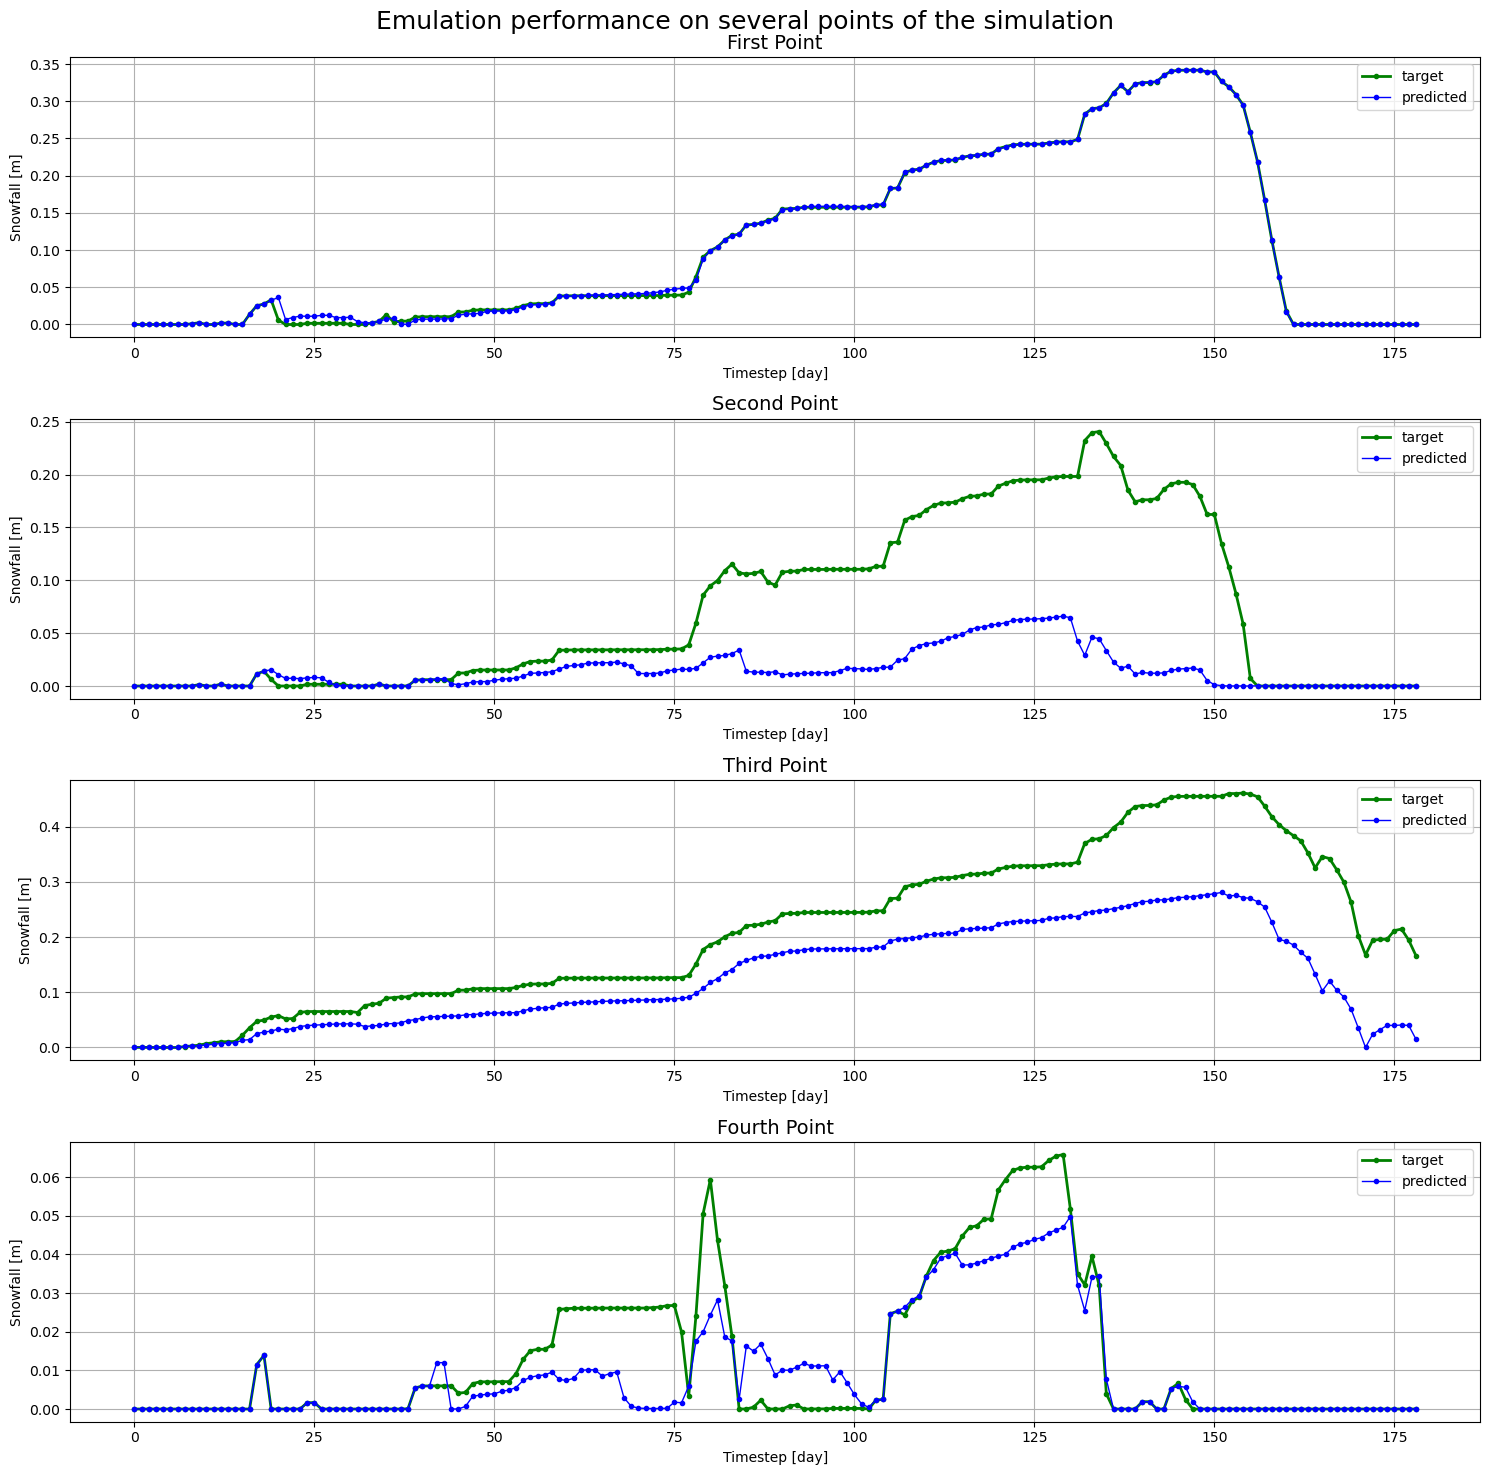

In [41]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Emulation performance on several points of the simulation', fontsize=18)

#---- point 1
ax1.plot(range(plot_xvalues), point_1, '.-', color = 'green', linewidth= 2)
ax1.plot(range(plot_xvalues), point_1_pred, '.-', color = 'blue', linewidth= 1.0)

#---- point 2
ax2.plot(range(plot_xvalues), point_2, '.-', color = 'green', linewidth= 2)
ax2.plot(range(plot_xvalues), point_2_pred, '.-', color = 'blue', linewidth= 1.0)

#---- point 3
ax3.plot(range(plot_xvalues), point_3, '.-', color = 'green', linewidth= 2)
ax3.plot(range(plot_xvalues), point_3_pred, '.-', color = 'blue', linewidth= 1.0)

#---- point 4
ax4.plot(range(plot_xvalues), point_4, '.-', color = 'green', linewidth= 2)
ax4.plot(range(plot_xvalues), point_4_pred, '.-', color = 'blue', linewidth= 1.0)

ax1.set_title('First Point', fontsize = 14)
ax1.set_ylabel('Snowfall [m]')
ax1.set_xlabel('Timestep [day]')
ax2.set_title('Second Point', fontsize = 14)
ax2.set_ylabel('Snowfall [m]')
ax2.set_xlabel('Timestep [day]')
ax3.set_title('Third Point', fontsize = 14)
ax3.set_ylabel('Snowfall [m]')
ax3.set_xlabel('Timestep [day]')
ax4.set_title('Fourth Point', fontsize = 14)
ax4.set_ylabel('Snowfall [m]')
ax4.set_xlabel('Timestep [day]')

ax1.legend(['target', 'predicted'])
ax2.legend(['target', 'predicted'])
ax3.legend(['target', 'predicted'])
ax4.legend(['target', 'predicted'])

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

fig.tight_layout()
# plt.subplot_tool()
plt.plot()
plt.savefig('drivers_timeseries.png')
plt.show()
plt.close()

# Cross correlation plots

Cross correlation plot shows the lags of two time series with each other.

In [ ]:
import statsmodels.tsa.stattools as stattools

# Compute Cross Correlations
ccs = stattools.ccf(point_4, point_4_pred)[:plot_xvalues]
nlags = len(ccs)

# Compute the Significance level
conf_level = 2 / np.sqrt(nlags)

# Draw Plot
plt.figure(figsize=(15,7))

plt.hlines(0, xmin=0, xmax=plot_xvalues, color='gray')  # 0 axis
plt.hlines(conf_level, xmin=0, xmax=plot_xvalues, color='gray')
plt.hlines(-conf_level, xmin=0, xmax=plot_xvalues, color='gray')

plt.bar(x=np.arange(len(ccs)), height=ccs, width=.3)

# Decoration
plt.title('$Cross\; Correlation\; Plot:\;$ \n $ simulated \; vs\; emulated$', fontsize=22)
plt.xlim(0,len(ccs))
plt.show()

# Autocorrelation plots

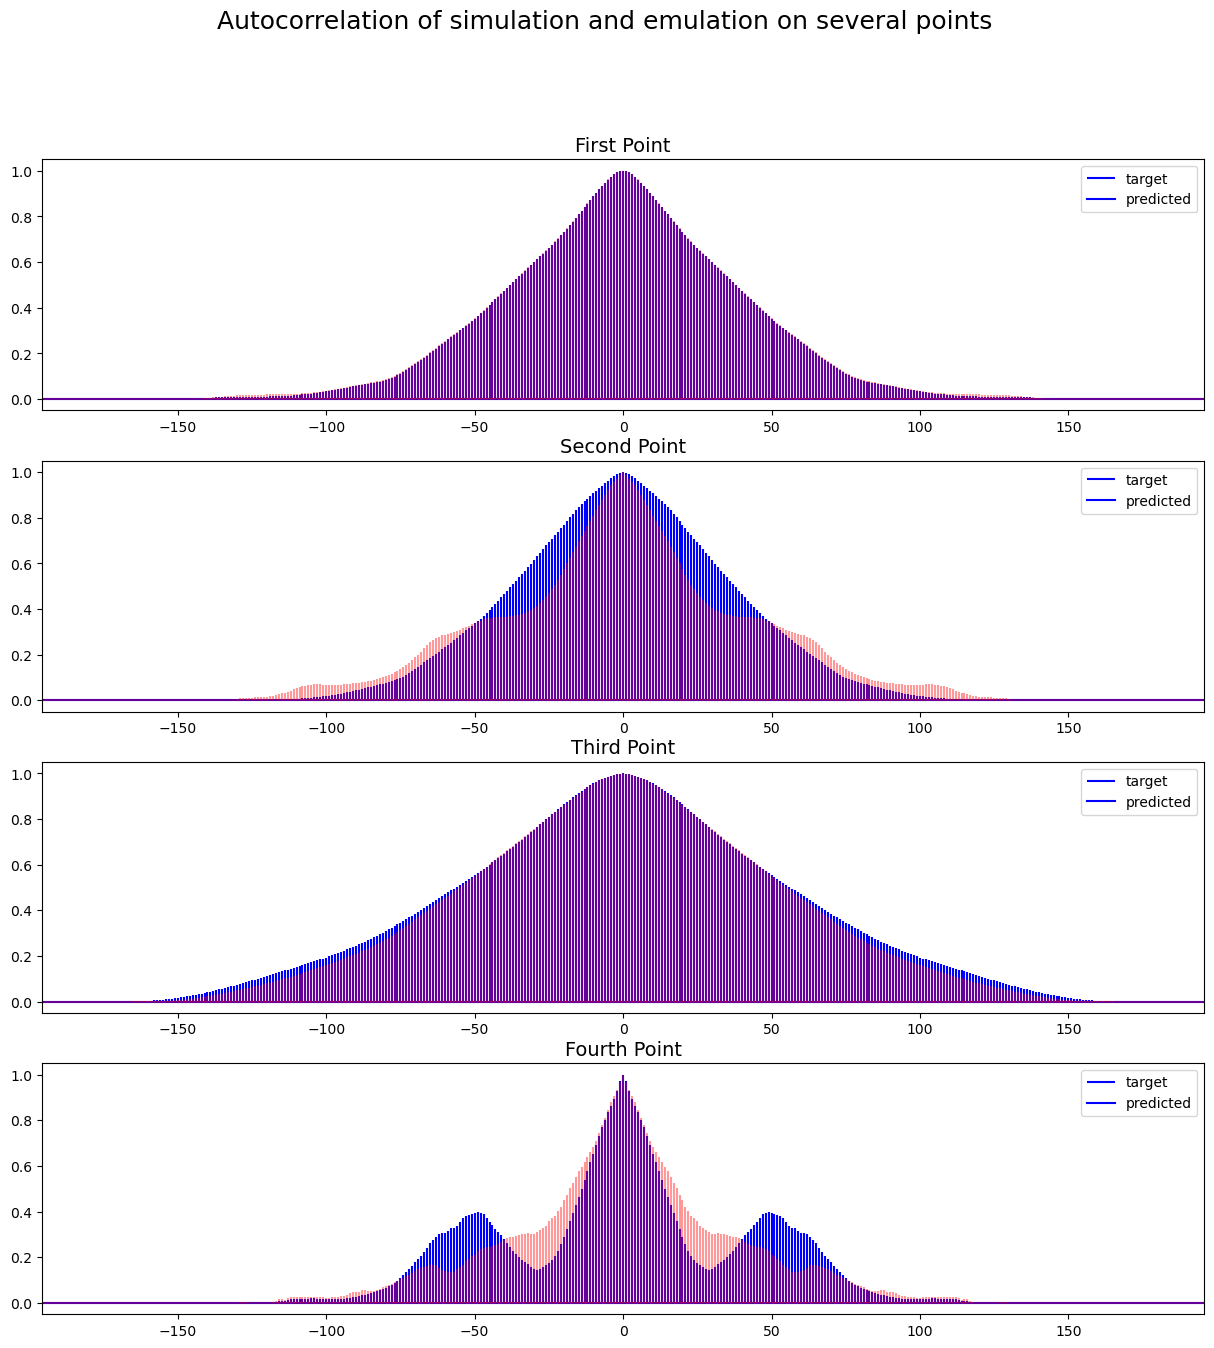

In [42]:
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1, figsize=(15,15))
fig.suptitle('Autocorrelation of simulation and emulation on several points', fontsize=18)

#---- point 1
ax1.acorr(point_1, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax1.acorr(point_1_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

#---- point 2
ax2.acorr(point_2, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax2.acorr(point_2_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

#---- point 3
ax3.acorr(point_3, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax3.acorr(point_3_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

#---- point 4
ax4.acorr(point_4, maxlags = plot_xvalues-1, color = 'blue', alpha = 1.0)
ax4.acorr(point_4_pred, maxlags = plot_xvalues-1, color = 'red', alpha=0.4, linestyle = '-')

ax1.set_title('First Point', fontsize = 14)
ax2.set_title('Second Point', fontsize = 14)
ax3.set_title('Third Point', fontsize = 14)
ax4.set_title('Fourth Point', fontsize = 14)


ax1.legend(['target', 'predicted'] )
ax2.legend(['target', 'predicted'])
ax3.legend(['target', 'predicted'])
ax4.legend(['target', 'predicted'])

# ax1.grid()
# ax2.grid()
# ax3.grid()
# ax4.grid()

# fig.tight_layout()
# plt.subplot_tool()
    #save figure for animation
plt.plot()
plt.savefig('drivers_autocorrelation.png')
plt.show()
plt.close()

# seperate timeseries

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8))= plt.subplots(4, 2)
fig.suptitle('compare time series patterns seperately')
#---- point 1
ax1.plot(range(plot_xvalues), point_1, 'o-')
ax1.set_ylabel('simulated value')

ax2.plot(range(plot_xvalues), point_1_pred, '.-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('predicted values')
#---- point 2
ax3.plot(range(plot_xvalues), point_2, 'o-')
ax3.set_ylabel('simulated value')

ax4.plot(range(plot_xvalues), point_2_pred, '.-')
ax4.set_xlabel('time (s)')
ax4.set_ylabel('predicted values')
#---- point 3
ax5.plot(range(plot_xvalues), point_3, 'o-')
ax5.set_ylabel('simulated value')

ax6.plot(range(plot_xvalues), point_3_pred, '.-')
ax6.set_xlabel('time (s)')
ax6.set_ylabel('predicted values')
#---- point 4
ax7.plot(range(plot_xvalues), point_4, 'o-')
ax7.set_ylabel('simulated value')

ax8.plot(range(plot_xvalues), point_4_pred, '.-')
ax8.set_xlabel('time (s)')
ax8.set_ylabel('predicted values')

fig.tight_layout(pad = 2)
plt.show()

### Animation of complete predicted simulation

In [44]:
import imageio.v2 as imageio


def save_plot_predict_rf(first_row, last_row, data, timestep):
    #subset the correct data
    data = data.iloc[first_row:last_row,:]

    #import libraries needed
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create figure for animation
    fig, ax = plt.subplots(figsize=(5,5))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cmap = cm.gist_yarg
    im = ax.imshow(data, interpolation='nearest', cmap=cmap, vmin=0, vmax=0.49)
    ax.set_title('Prediction timestep %i' %timestep)
    fig.colorbar(im,cax=cax, orientation='vertical', extend = 'both', ticks= [0.07,0.14,0.21,0.28,0.35, 0.42, 0.49])

    #save figure for animation
    plt.plot()
    plt.savefig(f'solution-{timestep}.png')
    plt.close()

last_row = 0
first_row = 0

# Create plots of simulation
for timestep in range(steps):
    # timestep is 0,1,2,3,4,5...
    # first rows is 0+niks, 1+ last_row

    last_row = first_row + vertical_pixels
    save_plot_predict_rf(first_row = first_row, last_row= last_row, data=framed_predictions, timestep= timestep)
    first_row = last_row

# Create animation
with imageio.get_writer('drivers_anim.mp4', format='FFMPEG', mode='I', fps=3) as writer:
    for i in range(steps):
        image = imageio.imread(f'solution-{i}.png')
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
